## Logic Based FizzBuzz Function [Software 1.0]

In [77]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import MinMaxScaler

In [48]:
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData)*0.01*TrainingPercent))
    d2 = rawData[:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, TrainingCount): 
    dataMatrix = rawData[TrainingCount:]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, TrainingCount): 
    t =rawData[TrainingCount:]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t


In [49]:
# This function takes dataset containing pairs and 
# returns a dataframe of n*21 dimention containing their image specifications 
# It performs feature concatination, i.e. It takes two sets of 9 features for each image
# and concats them into 18 features

def merge_data_set_feature_concatenation(image_specs, pair_set):
    df3 = pd.merge(pair_set, image_specs ,left_on = "img_id_A", right_on = "img_id",how="inner")
    df4 = pd.merge(df3, image_specs ,left_on = 'img_id_B', right_on = 'img_id',how="inner")
    
    targets = df4['target']

    _RawTarget = targets.values
    datasetStriped = df4.drop(['img_id_A', 'img_id_B', 'target','img_id_x', 'img_id_y'], axis=1)
    
    uniques = datasetStriped.apply(lambda x: x.nunique())
    datasetStriped = datasetStriped.drop(uniques[uniques==1].index, axis=1)
    
    _RawData = datasetStriped.values
    
    return _RawTarget, _RawData

# This function takes dataset containing pairs and 
# returns a dataframe of n*12 dimention containing their image specifications 
# It performs feature subtraction, i.e. It takes two sets of 9 features for each image
# and subtracts them and return 9 features

def merge_data_set_feature_subtraction(image_specs, pair_set):
    targets = pair_set['target']
    
    df3 = pd.merge(pair_set, image_specs ,left_on = "img_id_A", right_on = "img_id",how="inner")
    df3 = df3.drop(['img_id_A', 'img_id_B', 'target','img_id'], axis=1)
    

    df4 = pd.merge(pair_set, image_specs ,left_on = 'img_id_B', right_on = 'img_id',how="inner")
    df4 = df4.drop(['img_id_A', 'img_id_B', 'target','img_id'], axis=1)
    
    df5 = df3.sub(df4)
    df5 = df5.abs()
    
    uniques = df5.apply(lambda x: x.nunique())
    df5 = df5.drop(uniques[uniques==1].index, axis=1)
    
    temp_np = df5.values
    

    _RawTarget = targets.values
    _RawData = temp_np
    
    return _RawTarget, _RawData

In [58]:
def generate_training_validation_testing_ds(RawData, RawTarget):
    _TrainingTarget = GenerateTrainingTarget(RawTarget,90)
    _TrainingData   = GenerateTrainingDataMatrix(RawData,90)
    print("Training Target: "+ str(_TrainingTarget.shape))
    print("Training Data: "+ str(_TrainingData.shape))

    _TestDataAct = GenerateValTargetVector(RawTarget, (len(_TrainingTarget)))
    _TestData    = GenerateValData(RawData, (len(_TrainingTarget)))
    print("Testing Target: "+ str(_TestDataAct.shape))
    print("Testing Data: "+ str(_TestData.shape))
    
    return _TrainingTarget, _TrainingData, _TestDataAct, _TestData

## Model Definition

In [59]:
def get_model(input_size, drop_out, dl_1_nodes, dl_2_nodes, dl_3_nodes):

    
    model = Sequential()
    
    model.add(Dense(dl_1_nodes, input_dim=input_size))
    model.add(Activation('relu'))
  
    model.add(Dropout(drop_out))
    
    model.add(Dense(dl_2_nodes))
    model.add(Activation('relu'))

        
    model.add(Dropout(drop_out))
    
    model.add(Dense(dl_3_nodes))
    model.add(Activation('softmax'))

    
    model.summary()
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Human Observed Data

In [60]:
image_specs_df = pd.read_csv("HumanObserved-Dataset/HumanObserved-Features-Data/HumanObserved-Features-Data.csv", index_col=0)

same_pair_df = pd.read_csv("HumanObserved-Dataset/HumanObserved-Features-Data/same_pairs.csv")

diff_pair_df = pd.read_csv("HumanObserved-Dataset/HumanObserved-Features-Data/diffn_pairs.csv")


# create a dataframe by taking a subset from samples of different writers
# Since unmatched dataset is huge we are randomly creating a sample with same data size (791 rows)
# because if the amount of unmatched data overwhelms the matched data, the model may overfit

diff_pair_df_sample = diff_pair_df.sample(n=same_pair_df.shape[0], replace=True)

#Merging same and different writer's data set into one. (1582 rows)
dataset_pairs = pd.concat([diff_pair_df_sample,same_pair_df]).sample(frac=1).reset_index(drop=True)

In [63]:
RawTarget, RawData = merge_data_set_feature_concatenation(image_specs_df, dataset_pairs)
print("=========================")
print("== Human Observed Data ==")
print("==== Concatenation ======")
print("=========================")
print("RawData : " + str(RawData.shape))
print("RawTarget : " + str(RawTarget.shape))

RawTarget, RawData, TestingTarget, TestingData = generate_training_validation_testing_ds(RawData, RawTarget)

model = get_model(RawData.shape[1], 0.2, 512, 256, 2)

validation_data_split = 0.1

num_epochs = 10000  
model_batch_size = 128

tb_batch_size = 32

early_patience = 300

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

TargetVector = np_utils.to_categorical(np.array(RawTarget),2)

# model fit trains the data according to the parameters given to it.
history = model.fit(RawData
                    , TargetVector
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )




== Human Observed Data ==
==== Concatenation ======
RawData : (1582, 18)
RawTarget : (1582,)
Training Target: (1424,)
Training Data: (1424, 18)
Testing Target: (158,)
Testing Data: (158, 18)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 512)               9728      
_________________________________________________________________
activation_31 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_32 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_22 (Dropo

1281/1281 [==============================] - 1s 737us/step - loss: 0.6091 - acc: 0.6526 - val_loss: 0.8048 - val_acc: 0.4685
Epoch 48/10000
1281/1281 [==============================] - 1s 939us/step - loss: 0.6114 - acc: 0.6479 - val_loss: 0.7962 - val_acc: 0.4406
Epoch 49/10000
1281/1281 [==============================] - 1s 909us/step - loss: 0.6030 - acc: 0.6698 - val_loss: 0.7989 - val_acc: 0.4406
Epoch 50/10000
1281/1281 [==============================] - 1s 737us/step - loss: 0.6116 - acc: 0.6495 - val_loss: 0.7837 - val_acc: 0.5035
Epoch 51/10000
1281/1281 [==============================] - 1s 718us/step - loss: 0.6180 - acc: 0.6534 - val_loss: 0.7555 - val_acc: 0.5035
Epoch 52/10000
1281/1281 [==============================] - 1s 726us/step - loss: 0.6319 - acc: 0.6425 - val_loss: 0.8417 - val_acc: 0.4545
Epoch 53/10000
1281/1281 [==============================] - 1s 718us/step - loss: 0.6141 - acc: 0.6542 - val_loss: 0.7646 - val_acc: 0.5175
Epoch 54/10000
1281/1281 [=========

1281/1281 [==============================] - 1s 732us/step - loss: 0.4962 - acc: 0.7471 - val_loss: 0.8749 - val_acc: 0.5035
Epoch 106/10000
1281/1281 [==============================] - 1s 769us/step - loss: 0.5331 - acc: 0.7260 - val_loss: 0.8927 - val_acc: 0.5175
Epoch 107/10000
1281/1281 [==============================] - 1s 703us/step - loss: 0.5251 - acc: 0.7244 - val_loss: 0.8972 - val_acc: 0.4965
Epoch 108/10000
1281/1281 [==============================] - 1s 708us/step - loss: 0.5057 - acc: 0.7486 - val_loss: 0.9290 - val_acc: 0.4406
Epoch 109/10000
1281/1281 [==============================] - 1s 714us/step - loss: 0.5001 - acc: 0.7564 - val_loss: 0.8929 - val_acc: 0.5245
Epoch 110/10000
1281/1281 [==============================] - 1s 858us/step - loss: 0.4732 - acc: 0.7806 - val_loss: 0.9297 - val_acc: 0.4895
Epoch 111/10000
1281/1281 [==============================] - 1s 844us/step - loss: 0.4737 - acc: 0.7658 - val_loss: 0.9478 - val_acc: 0.5035
Epoch 112/10000
1281/1281 [==

1281/1281 [==============================] - 1s 716us/step - loss: 0.3204 - acc: 0.8696 - val_loss: 1.2052 - val_acc: 0.4895
Epoch 164/10000
1281/1281 [==============================] - 1s 827us/step - loss: 0.3348 - acc: 0.8587 - val_loss: 1.2281 - val_acc: 0.5105
Epoch 165/10000
1281/1281 [==============================] - 1s 721us/step - loss: 0.3332 - acc: 0.8579 - val_loss: 1.2471 - val_acc: 0.4895
Epoch 166/10000
1281/1281 [==============================] - 1s 714us/step - loss: 0.3344 - acc: 0.8579 - val_loss: 1.2204 - val_acc: 0.4825
Epoch 167/10000
1281/1281 [==============================] - 1s 705us/step - loss: 0.3449 - acc: 0.8454 - val_loss: 1.1745 - val_acc: 0.5175
Epoch 168/10000
1281/1281 [==============================] - 1s 787us/step - loss: 0.3232 - acc: 0.8564 - val_loss: 1.2186 - val_acc: 0.4965
Epoch 169/10000
1281/1281 [==============================] - 1s 767us/step - loss: 0.3135 - acc: 0.8743 - val_loss: 1.2731 - val_acc: 0.4545
Epoch 170/10000
1281/1281 [==

1281/1281 [==============================] - 1s 972us/step - loss: 0.3422 - acc: 0.8392 - val_loss: 1.3400 - val_acc: 0.4965
Epoch 222/10000
1281/1281 [==============================] - 2s 1ms/step - loss: 0.3419 - acc: 0.8470 - val_loss: 1.3589 - val_acc: 0.5245
Epoch 223/10000
1281/1281 [==============================] - 1s 981us/step - loss: 0.3299 - acc: 0.8571 - val_loss: 1.3315 - val_acc: 0.4965
Epoch 224/10000
1281/1281 [==============================] - 1s 1ms/step - loss: 0.3028 - acc: 0.8665 - val_loss: 1.4914 - val_acc: 0.4545
Epoch 225/10000
1281/1281 [==============================] - 1s 730us/step - loss: 0.3337 - acc: 0.8470 - val_loss: 1.5035 - val_acc: 0.4755
Epoch 226/10000
1281/1281 [==============================] - 1s 986us/step - loss: 0.3747 - acc: 0.8345 - val_loss: 1.4128 - val_acc: 0.5105
Epoch 227/10000
1281/1281 [==============================] - 1s 751us/step - loss: 0.3602 - acc: 0.8267 - val_loss: 1.4173 - val_acc: 0.5175
Epoch 228/10000
1281/1281 [======

1281/1281 [==============================] - 1s 735us/step - loss: 0.2321 - acc: 0.9157 - val_loss: 1.5839 - val_acc: 0.4965
Epoch 280/10000
1281/1281 [==============================] - 1s 699us/step - loss: 0.2188 - acc: 0.9063 - val_loss: 1.6563 - val_acc: 0.5175
Epoch 281/10000
1281/1281 [==============================] - 1s 778us/step - loss: 0.2248 - acc: 0.9212 - val_loss: 1.6434 - val_acc: 0.5315
Epoch 282/10000
1281/1281 [==============================] - 1s 710us/step - loss: 0.2293 - acc: 0.9126 - val_loss: 1.6742 - val_acc: 0.5105
Epoch 283/10000
1281/1281 [==============================] - 1s 959us/step - loss: 0.2074 - acc: 0.9235 - val_loss: 1.6705 - val_acc: 0.5175
Epoch 284/10000
1281/1281 [==============================] - 1s 893us/step - loss: 0.2065 - acc: 0.9258 - val_loss: 1.7078 - val_acc: 0.5315
Epoch 285/10000
1281/1281 [==============================] - 1s 1ms/step - loss: 0.1909 - acc: 0.9274 - val_loss: 1.7633 - val_acc: 0.5105
Epoch 286/10000
1281/1281 [====

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a43379550>,
      dtype=object)

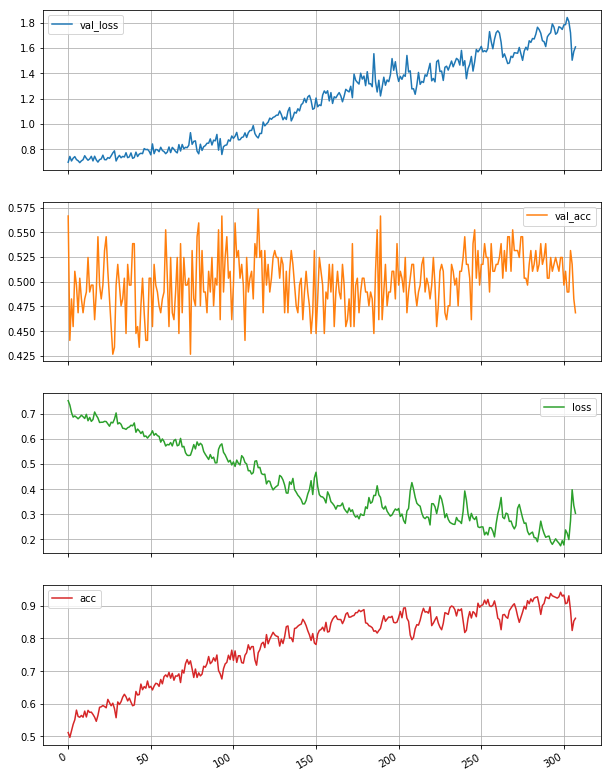

In [64]:
%matplotlib inline

df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [86]:
prediction = model.predict(TestingData)
prediction_classes = prediction.argmax(axis=-1)
score = accuracy_score(TestingTarget, prediction_classes)
print("Accuracy: " + str(score))


Accuracy: 0.4873417721518987


In [87]:
RawTarget, RawData = merge_data_set_feature_subtraction(image_specs_df, dataset_pairs)
print("=========================")
print("== Human Observed Data ==")
print("==== Subtraction ======")
print("=========================")
print("RawData : " + str(RawData.shape))
print("RawTarget : " + str(RawTarget.shape))

RawTarget, RawData, TestingTarget, TestingData = generate_training_validation_testing_ds(RawData, RawTarget)


model = get_model(RawData.shape[1], 0.2, 512, 256, 2)

validation_data_split = 0.2

num_epochs = 10000  
model_batch_size = 128

tb_batch_size = 32

early_patience = 300

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

TargetVector = np_utils.to_categorical(np.array(RawTarget),2)

# model fit trains the data according to the parameters given to it.
history = model.fit(RawData
                    , TargetVector
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )



== Human Observed Data ==
==== Subtraction ======
RawData : (1582, 9)
RawTarget : (1582,)
Training Target: (1424,)
Training Data: (1424, 9)
Testing Target: (158,)
Testing Data: (158, 9)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 512)               5120      
_________________________________________________________________
activation_34 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_35 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_24 (Dropout)  

1139/1139 [==============================] - 1s 658us/step - loss: 0.5412 - acc: 0.7173 - val_loss: 0.8216 - val_acc: 0.5123
Epoch 48/10000
1139/1139 [==============================] - 1s 650us/step - loss: 0.5230 - acc: 0.7384 - val_loss: 0.8507 - val_acc: 0.5193
Epoch 49/10000
1139/1139 [==============================] - 1s 652us/step - loss: 0.5341 - acc: 0.7164 - val_loss: 0.8366 - val_acc: 0.5018
Epoch 50/10000
1139/1139 [==============================] - 1s 656us/step - loss: 0.5361 - acc: 0.7349 - val_loss: 0.8472 - val_acc: 0.5088
Epoch 51/10000
1139/1139 [==============================] - 1s 659us/step - loss: 0.5286 - acc: 0.7287 - val_loss: 0.8647 - val_acc: 0.5053
Epoch 52/10000
1139/1139 [==============================] - 1s 655us/step - loss: 0.5210 - acc: 0.7524 - val_loss: 0.8642 - val_acc: 0.5158
Epoch 53/10000
1139/1139 [==============================] - 1s 824us/step - loss: 0.5229 - acc: 0.7471 - val_loss: 0.8702 - val_acc: 0.5053
Epoch 54/10000
1139/1139 [=========

1139/1139 [==============================] - 1s 653us/step - loss: 0.4235 - acc: 0.7998 - val_loss: 1.1078 - val_acc: 0.4982
Epoch 106/10000
1139/1139 [==============================] - 1s 653us/step - loss: 0.4469 - acc: 0.7875 - val_loss: 1.1036 - val_acc: 0.4842
Epoch 107/10000
1139/1139 [==============================] - 1s 654us/step - loss: 0.4200 - acc: 0.7893 - val_loss: 1.0912 - val_acc: 0.4737
Epoch 108/10000
1139/1139 [==============================] - 1s 654us/step - loss: 0.4275 - acc: 0.7893 - val_loss: 1.0767 - val_acc: 0.4947
Epoch 109/10000
1139/1139 [==============================] - 1s 688us/step - loss: 0.4226 - acc: 0.7989 - val_loss: 1.0982 - val_acc: 0.4842
Epoch 110/10000
1139/1139 [==============================] - 1s 656us/step - loss: 0.4140 - acc: 0.8051 - val_loss: 1.1264 - val_acc: 0.4842
Epoch 111/10000
1139/1139 [==============================] - 1s 657us/step - loss: 0.4098 - acc: 0.7998 - val_loss: 1.1126 - val_acc: 0.4947
Epoch 112/10000
1139/1139 [==

1139/1139 [==============================] - 1s 656us/step - loss: 0.3908 - acc: 0.8060 - val_loss: 1.2256 - val_acc: 0.4982
Epoch 164/10000
1139/1139 [==============================] - 1s 653us/step - loss: 0.3599 - acc: 0.8270 - val_loss: 1.2470 - val_acc: 0.4912
Epoch 165/10000
1139/1139 [==============================] - 1s 682us/step - loss: 0.3694 - acc: 0.8183 - val_loss: 1.2549 - val_acc: 0.4982
Epoch 166/10000
1139/1139 [==============================] - 1s 653us/step - loss: 0.3555 - acc: 0.8227 - val_loss: 1.2514 - val_acc: 0.4912
Epoch 167/10000
1139/1139 [==============================] - 1s 659us/step - loss: 0.3646 - acc: 0.8227 - val_loss: 1.2473 - val_acc: 0.5053
Epoch 168/10000
1139/1139 [==============================] - 1s 658us/step - loss: 0.3600 - acc: 0.8323 - val_loss: 1.2767 - val_acc: 0.4912
Epoch 169/10000
1139/1139 [==============================] - 1s 651us/step - loss: 0.3677 - acc: 0.8235 - val_loss: 1.2859 - val_acc: 0.4877
Epoch 170/10000
1139/1139 [==

1139/1139 [==============================] - 1s 699us/step - loss: 0.3502 - acc: 0.8095 - val_loss: 1.3648 - val_acc: 0.4947
Epoch 222/10000
1139/1139 [==============================] - 1s 686us/step - loss: 0.3363 - acc: 0.8323 - val_loss: 1.3736 - val_acc: 0.4842
Epoch 223/10000
1139/1139 [==============================] - 1s 689us/step - loss: 0.3366 - acc: 0.8262 - val_loss: 1.3500 - val_acc: 0.4982
Epoch 224/10000
1139/1139 [==============================] - 1s 691us/step - loss: 0.3454 - acc: 0.8183 - val_loss: 1.3434 - val_acc: 0.5088
Epoch 225/10000
1139/1139 [==============================] - 1s 687us/step - loss: 0.3259 - acc: 0.8341 - val_loss: 1.3733 - val_acc: 0.4982
Epoch 226/10000
1139/1139 [==============================] - 1s 689us/step - loss: 0.3380 - acc: 0.8323 - val_loss: 1.4182 - val_acc: 0.4842
Epoch 227/10000
1139/1139 [==============================] - 1s 693us/step - loss: 0.3476 - acc: 0.8218 - val_loss: 1.3844 - val_acc: 0.4982
Epoch 228/10000
1139/1139 [==

1139/1139 [==============================] - 1s 701us/step - loss: 0.3450 - acc: 0.8183 - val_loss: 1.3979 - val_acc: 0.5123
Epoch 280/10000
1139/1139 [==============================] - 1s 686us/step - loss: 0.3301 - acc: 0.8183 - val_loss: 1.4068 - val_acc: 0.4772
Epoch 281/10000
1139/1139 [==============================] - 1s 687us/step - loss: 0.3237 - acc: 0.8349 - val_loss: 1.4263 - val_acc: 0.4982
Epoch 282/10000
1139/1139 [==============================] - 1s 693us/step - loss: 0.3367 - acc: 0.8306 - val_loss: 1.4354 - val_acc: 0.4842
Epoch 283/10000
1139/1139 [==============================] - 1s 686us/step - loss: 0.3352 - acc: 0.8191 - val_loss: 1.4549 - val_acc: 0.5018
Epoch 284/10000
1139/1139 [==============================] - 1s 693us/step - loss: 0.3179 - acc: 0.8455 - val_loss: 1.4311 - val_acc: 0.5123
Epoch 285/10000
1139/1139 [==============================] - 1s 689us/step - loss: 0.3260 - acc: 0.8349 - val_loss: 1.4245 - val_acc: 0.5053
Epoch 286/10000
1139/1139 [==

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a448e4e10>,
      dtype=object)

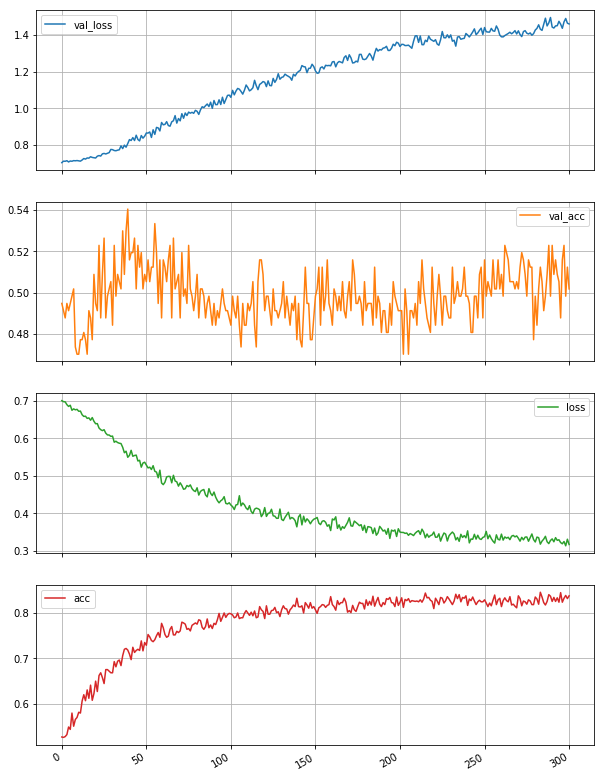

In [88]:
%matplotlib inline

df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [89]:
prediction = model.predict(TestingData)
prediction_classes = prediction.argmax(axis=-1)
score = accuracy_score(TestingTarget, prediction_classes)
print("Accuracy: " + str(score))

Accuracy: 0.4936708860759494


# Gradient Structural Concavity (GSC) Data

In [90]:
image_specs_df = pd.read_csv("GSC-Dataset/GSC-Features-Data/GSC-Features.csv")

same_pair_df = pd.read_csv("GSC-Dataset/GSC-Features-Data/same_pairs.csv")

diff_pair_df = pd.read_csv("GSC-Dataset/GSC-Features-Data/diffn_pairs.csv")


same_pair_df = same_pair_df.sample(n=5000, replace=True)

diff_pair_df_sample = diff_pair_df.sample(n=same_pair_df.shape[0], replace=True)

dataset_pairs = pd.concat([diff_pair_df_sample,same_pair_df]).sample(frac=1).reset_index(drop=True)

In [91]:
RawTarget, RawData = merge_data_set_feature_concatenation(image_specs_df, dataset_pairs)
print("=========================")
print("== Gradient Structural Concavity Data ==")
print("==== Concatenation ======")
print("=========================")
print("RawData : " + str(RawData.shape))
print("RawTarget : " + str(RawTarget.shape))

RawTarget, RawData, TestingTarget, TestingData = generate_training_validation_testing_ds(RawData, RawTarget)


model = get_model(RawData.shape[1], 0.1, 512, 128, 2)

validation_data_split = 0.1

num_epochs = 10000  
model_batch_size = 128

tb_batch_size = 32

early_patience = 100

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

TargetVector = np_utils.to_categorical(np.array(RawTarget),2)

# model fit trains the data according to the parameters given to it.
history = model.fit(RawData
                    , TargetVector
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )



== Gradient Structural Concavity Data ==
==== Concatenation ======
RawData : (10000, 1013)
RawTarget : (10000,)
Training Target: (9000,)
Training Data: (9000, 1013)
Testing Target: (1000,)
Testing Data: (1000, 1013)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 512)               519168    
_________________________________________________________________
activation_37 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               65664     
_________________________________________________________________
activation_38 (Activation)   (None, 128)               0         
__________________________________________________________

Epoch 48/10000
7200/7200 [==============================] - 13s 2ms/step - loss: 0.0106 - acc: 0.9967 - val_loss: 1.4305 - val_acc: 0.7411
Epoch 49/10000
7200/7200 [==============================] - 13s 2ms/step - loss: 0.0112 - acc: 0.9965 - val_loss: 1.6749 - val_acc: 0.7383
Epoch 50/10000
7200/7200 [==============================] - 13s 2ms/step - loss: 0.0219 - acc: 0.9932 - val_loss: 1.4674 - val_acc: 0.7483
Epoch 51/10000
7200/7200 [==============================] - 13s 2ms/step - loss: 0.0291 - acc: 0.9899 - val_loss: 1.2370 - val_acc: 0.7789
Epoch 52/10000
7200/7200 [==============================] - 15s 2ms/step - loss: 0.0212 - acc: 0.9928 - val_loss: 1.3567 - val_acc: 0.7483
Epoch 53/10000
7200/7200 [==============================] - 13s 2ms/step - loss: 0.0082 - acc: 0.9971 - val_loss: 1.3402 - val_acc: 0.7839
Epoch 54/10000
7200/7200 [==============================] - 13s 2ms/step - loss: 0.0061 - acc: 0.9978 - val_loss: 1.4607 - val_acc: 0.7589
Epoch 55/10000
7200/7200 [=

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a3e23cd30>,
      dtype=object)

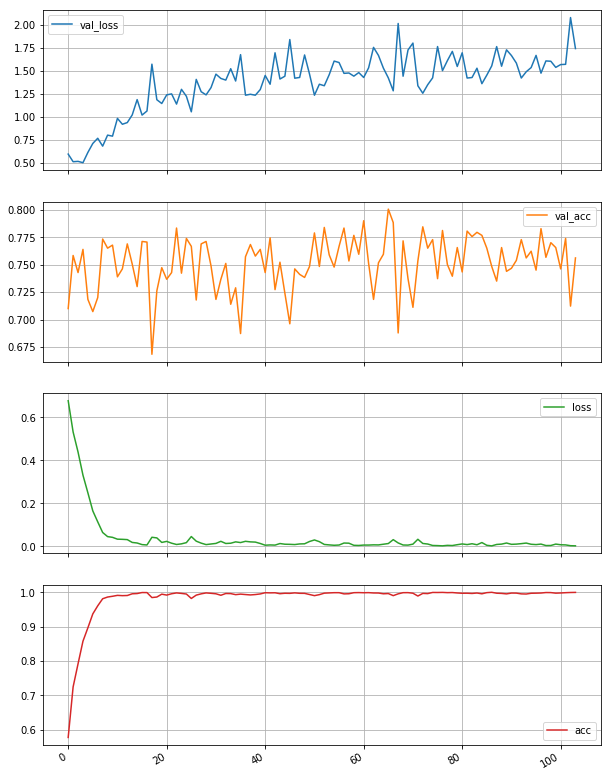

In [92]:
%matplotlib inline

df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [93]:
prediction = model.predict(TestingData)
prediction_classes = prediction.argmax(axis=-1)
score = accuracy_score(TestingTarget, prediction_classes)
print("Accuracy: " + str(score))

Accuracy: 0.776


In [102]:
RawTarget, RawData = merge_data_set_feature_subtraction(image_specs_df, dataset_pairs)
print("=========================")
print("== Gradient Structural Concavity Data ==")
print("==== Subtraction ======")
print("=========================")
print("RawData : " + str(RawData.shape))
print("RawTarget : " + str(RawTarget.shape))

RawTarget, RawData, TestingTarget, TestingData = generate_training_validation_testing_ds(RawData, RawTarget)


model = get_model(RawData.shape[1], 0.1, 512, 128, 2)

validation_data_split = 0.1

num_epochs = 10000  
model_batch_size = 128

tb_batch_size = 32

early_patience = 100

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

TargetVector = np_utils.to_categorical(np.array(RawTarget),2)

# model fit trains the data according to the parameters given to it.
history = model.fit(RawData
                    , TargetVector
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )



== Gradient Structural Concavity Data ==
==== Subtraction ======
RawData : (10000, 509)
RawTarget : (10000,)
Training Target: (9000,)
Training Data: (9000, 509)
Testing Target: (1000,)
Testing Data: (1000, 509)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 512)               261120    
_________________________________________________________________
activation_49 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               65664     
_________________________________________________________________
activation_50 (Activation)   (None, 128)               0         
_______________________________________________________________

Epoch 48/10000
7200/7200 [==============================] - 10s 1ms/step - loss: 0.1733 - acc: 0.8826 - val_loss: 1.7168 - val_acc: 0.5000
Epoch 49/10000
7200/7200 [==============================] - 10s 1ms/step - loss: 0.1738 - acc: 0.8811 - val_loss: 1.4802 - val_acc: 0.5028
Epoch 50/10000
7200/7200 [==============================] - 11s 2ms/step - loss: 0.1748 - acc: 0.8790 - val_loss: 1.7053 - val_acc: 0.4978
Epoch 51/10000
7200/7200 [==============================] - 11s 2ms/step - loss: 0.1757 - acc: 0.8806 - val_loss: 1.5980 - val_acc: 0.5000
Epoch 52/10000
7200/7200 [==============================] - 10s 1ms/step - loss: 0.1741 - acc: 0.8788 - val_loss: 1.6100 - val_acc: 0.5000
Epoch 53/10000
7200/7200 [==============================] - 10s 1ms/step - loss: 0.1769 - acc: 0.8831 - val_loss: 1.7158 - val_acc: 0.4994
Epoch 54/10000
7200/7200 [==============================] - 16s 2ms/step - loss: 0.1798 - acc: 0.8806 - val_loss: 1.5918 - val_acc: 0.5044
Epoch 55/10000
7200/7200 [=

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a4b382630>,
      dtype=object)

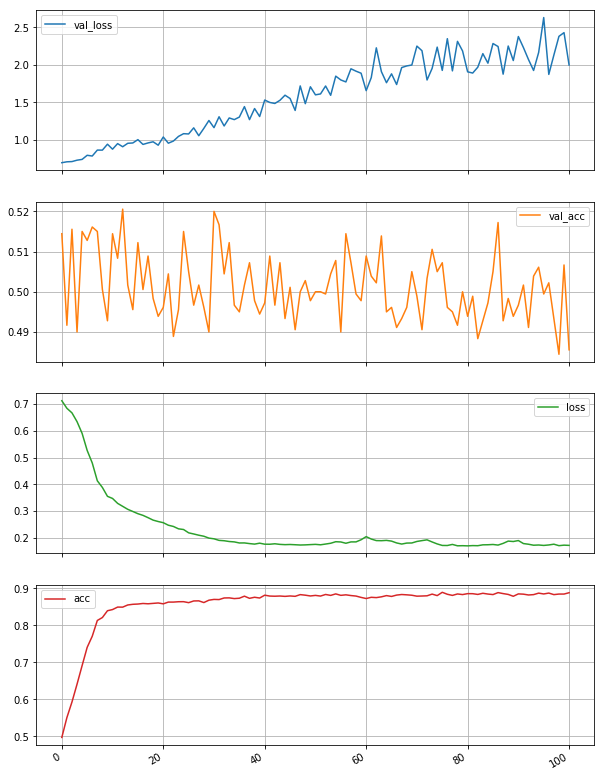

In [103]:
%matplotlib inline

df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [104]:
prediction = model.predict(TestingData)
prediction_classes = prediction.argmax(axis=-1)
score = accuracy_score(TestingTarget, prediction_classes)
print("Accuracy: " + str(score))

Accuracy: 0.508
